In [1]:
import os 
import re
import napari
from tifffile import imread, imwrite
from skimage.measure import regionprops_table
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading data

In [2]:
data_dir = r'D:\data_analysis\2023_Andrew\data'

## Read in data legend

In [3]:
legend_path = r'D:\data_analysis\2023_Andrew\data_analysis\im_resolutions.csv'
df_legend = pd.read_csv(legend_path,index_col=0)
df_legend = df_legend.reset_index()
df_legend

,id,condition,number,mag,nm/px
0,1,DCA,1,1500,6.745753
1,2,DCA,2,2000,5.059315
2,3,DCA,3,2500,4.047452
3,4,DCA,4,2500,4.047452
4,5,DCA,5,2500,4.047452
5,6,DCA,6,2000,5.059315
6,7,DCA,7,2000,5.059315
7,8,DCA,8,2000,5.059315
8,9,DCA,9,2000,5.059315
9,10,DCA,10,2000,5.059315


## Calculate properties

In [4]:
properties = ['label','area','axis_major_length','axis_minor_length','eccentricity','centroid','bbox','mean_intensity','image_intensity']

sub_dir_list = [x for x in os.listdir(data_dir) if not('Store' in x)]

df_list =[]

for sub_dir in sub_dir_list:

    # list the directory
    sub_sub_dir_list = [x for x in os.listdir(os.path.join(data_dir,sub_dir)) if '300' in x]

    for sub_sub_dir in sub_sub_dir_list:

        # list the the directory
        sub_sub_path = os.path.join(data_dir,sub_dir,sub_sub_dir)
        sub_sub_sub_dir_list = [x for x in os.listdir(sub_sub_path) if os.path.isdir(os.path.join(sub_sub_path,x))]

        for sub_sub_sub_dir in sub_sub_sub_dir_list:

            print(os.path.join(data_dir,sub_dir,sub_sub_dir,sub_sub_sub_dir))

            # get list of all the images in this directory
            im_list = os.listdir(os.path.join(data_dir,sub_dir,sub_sub_dir,sub_sub_sub_dir))

            # find the intensity value image
            image_em_name = [x for x in im_list if (('tif' in x) and not(('er' in x) or ('ER' in x) or ('frags' in x) or ('cells.' in x) or ('mit' in x)))]
            
            # check that there is only intensity image in this directory
            if (len(image_em_name) == 1):
                image_em_name = image_em_name[0]
                print('Image found.')
            else:
                print('Error in finding EM image.')

            
            # read in intensity image
            image_em_path = os.path.join(sub_sub_path,sub_sub_sub_dir,image_em_name)
            image_em = imread(image_em_path)

            # find and read in mitochondria mask
            labels_mitos_name = [x for x in im_list if (('.tif' in x) and ('corr' in x))][0]
            labels_mitos_path = os.path.join(sub_sub_path,sub_sub_sub_dir,labels_mitos_name)
            labels_mitos = imread(labels_mitos_path)

            # find and read in cell mask
            labels_cells_name = [x for x in im_list if (('.tif' in x) and ('cells.' in x))][0]
            labels_cells_path = os.path.join(sub_sub_path,sub_sub_sub_dir,labels_cells_name)
            labels_cells = imread(labels_cells_path)

            # find and read in cell fragments mask
            labels_frags_name = [x for x in im_list if (('.tif' in x) and ('frags.' in x))][0]
            labels_frags_path = os.path.join(sub_sub_path,sub_sub_sub_dir,labels_frags_name)
            labels_frags = imread(labels_frags_path)


            ###################################################################
            # calculate mitochondria parameters

            # create image of cells and cell fragments
            belonging_image = np.stack([image_em[:labels_cells.shape[0],:labels_cells.shape[1]],labels_cells,labels_frags],axis=2)

            data = regionprops_table(labels_mitos,intensity_image = belonging_image,properties=properties)
            df = pd.DataFrame(data)
            ###################################################################
            # clean mitochondria touching the edges
            sel_vector = ((df['bbox-0'] < 2) | (df['bbox-1'] < 2) | (df['bbox-2'] > 3997) | (df['bbox-3']>3917))
            df = df.drop(df.index[sel_vector],axis=0)

            ###################################################################

            # add information about condition
            df['condition'] = sub_dir.split(' ')[0]
            df['source_im'] = sub_sub_sub_dir

            pattern = r'pic\s*(\d{1,2})'
            pic_num = [int(re.search(pattern, t, re.IGNORECASE).group(1)) for t in df.source_im]
            df['pic_num'] = pic_num

            # collect data frames
            df_list.append(df)

            
df_all = pd.concat(df_list)

D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 1\DCA 300k pic1 collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 10\300k_dca_pic10_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 11\300k_dca_pic11_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 12\300k_dca_pic12_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 13\300k_DCA_pic13_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 14\300k_dca_pic14_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 2\300k_dca_pic2_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 3\300k_dca_pic3_collected
Image found.
D:\data_analysis\2023_Andrew\data\DCA treated pmel t cells day 8\300k pic 4\300k_dca_p

In [5]:
#df_all = pd.concat(df_list)

In [6]:
# add info about magnification to the main frame

df = pd.merge(left=df_all,right=df_legend,left_on=['condition','pic_num'],right_on=['condition','number'],how='left')
df.drop(['id','number'],inplace=True,axis=1)
df

,label,area,axis_major_length,axis_minor_length,eccentricity,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity-0,mean_intensity-1,mean_intensity-2,image_intensity,condition,source_im,pic_num,mag,nm/px
0,2,11515,146.475653,100.253307,0.729072,133.274512,1603.028398,71,1545,198,1666,54.517586,0.0,902.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",DCA,DCA 300k pic1 collected,1,1500,6.745753
1,6,10066,144.053317,89.994559,0.780840,247.461752,3176.133817,199,3100,293,3244,59.677628,0.0,904.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",DCA,DCA 300k pic1 collected,1,1500,6.745753
2,7,4712,90.806632,67.026811,0.674662,295.137946,3263.221138,252,3226,340,3301,62.523132,0.0,904.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",DCA,DCA 300k pic1 collected,1,1500,6.745753
3,11,6722,101.667665,85.013553,0.548439,356.471437,2735.329961,316,2684,403,2786,65.180155,0.0,904.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",DCA,DCA 300k pic1 collected,1,1500,6.745753
4,14,7555,100.724645,95.620566,0.314292,398.018134,3190.147981,347,3141,450,3239,85.930377,0.0,904.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",DCA,DCA 300k pic1 collected,1,1500,6.745753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,42,22561,212.490837,136.646431,0.765808,2819.639910,1653.307079,2741,1550,2905,1750,102.602854,17.0,0.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",untreated,300k_ut_pic9_collected,9,2000,5.059315
499,43,9762,123.125924,101.356738,0.567758,2938.947859,3042.856279,2887,2984,2990,3107,67.945298,14.0,0.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",untreated,300k_ut_pic9_collected,9,2000,5.059315
500,46,3,3.265986,0.000000,1.000000,2269.000000,2002.000000,2268,2002,2271,2003,126.333333,17.0,0.0,"[[[118, 17, 0]], [[129, 17, 0]], [[132, 17, 0]]]",untreated,300k_ut_pic9_collected,9,2000,5.059315
501,47,7,3.023716,2.799417,0.377964,2289.000000,1965.285714,2288,1964,2291,1967,110.857143,17.0,0.0,"[[[0, 0, 0], [98, 17, 0], [107, 17, 0]], [[106...",untreated,300k_ut_pic9_collected,9,2000,5.059315


In [7]:
# drop remaining small areas
df.drop(df.index[df.area<200],axis=0,inplace=True)
len(df)

462

In [8]:
# save images of individual mitochondria

save_dir = r'D:\data_analysis\2023_Andrew\individual_mitochondria'

for i,m in df.iterrows():

    m_name = f'{m.condition}_{str(m.label).zfill(4)}_im_{str(m.pic_num).zfill(2)}_mag_{m.mag}.tiff'
    m_path = os.path.join(save_dir,m_name)

    imwrite(m_path,m.image_intensity[:,:,0].astype('uint8'))

In [9]:
# save images of individual mitochondria (magnification 2500)

save_dir = r'D:\data_analysis\2023_Andrew\individual_mitochondria_2500'

for i,m in df.iterrows():

    if m.mag==2500:

        m_name = f'{m.condition}_{str(m.label).zfill(4)}_im_{str(m.pic_num).zfill(2)}_mag_{m.mag}.tiff'
        m_path = os.path.join(save_dir,m_name)

        imwrite(m_path,m.image_intensity[:,:,0].astype('uint8'))

In [10]:
df['area_scaled'] = df.area * df['nm/px'] * df['nm/px']

In [11]:
df.to_csv(r'D:\data_analysis\2023_Andrew\data_analysis\230907_results.csv')

### Plot per category

<AxesSubplot:xlabel='condition', ylabel='area_scaled'>

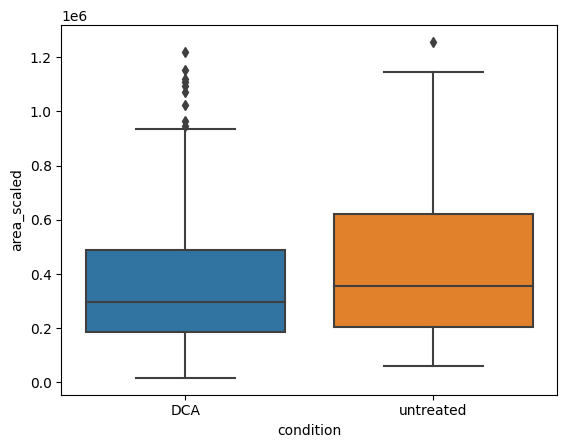

In [12]:
sns.boxplot(data=df,x='condition',y='area_scaled')

<AxesSubplot:xlabel='condition', ylabel='area_scaled'>

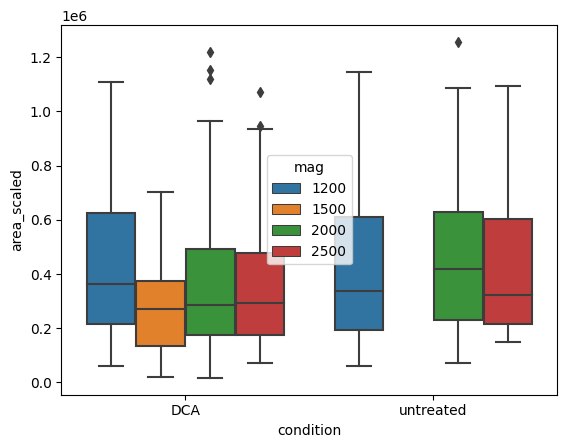

In [13]:
# just a test that area was correctly scaled
sns.boxplot(data=df,x='condition',y='area_scaled',hue='mag')

<AxesSubplot:xlabel='condition', ylabel='eccentricity'>

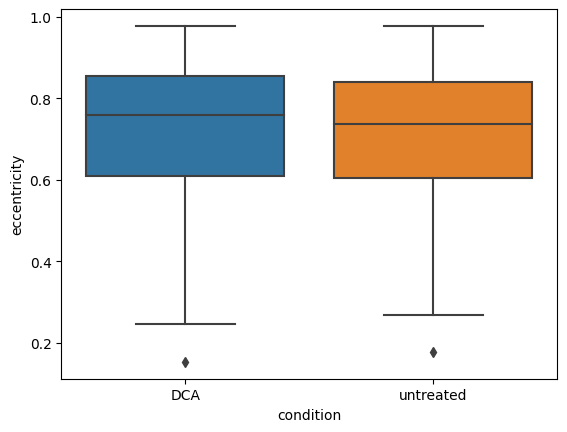

In [14]:
sns.boxplot(data=df,x='condition',y='eccentricity')
# 0 - circle

### Plotted only from high mag images

In [15]:
cat = ['untreated','DCA']
for c in cat:
    print(f'Number of mito in category {c} = {sum((df.mag==2500) & (df.condition==c))}')

Number of mito in category untreated = 22
Number of mito in category DCA = 37


<AxesSubplot:xlabel='condition', ylabel='area_scaled'>

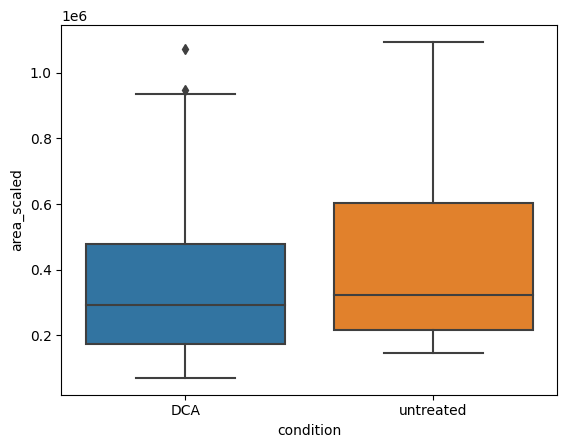

In [16]:
sns.boxplot(data=df.loc[df.mag==2500,:],x='condition',y='area_scaled')

<AxesSubplot:xlabel='condition', ylabel='eccentricity'>

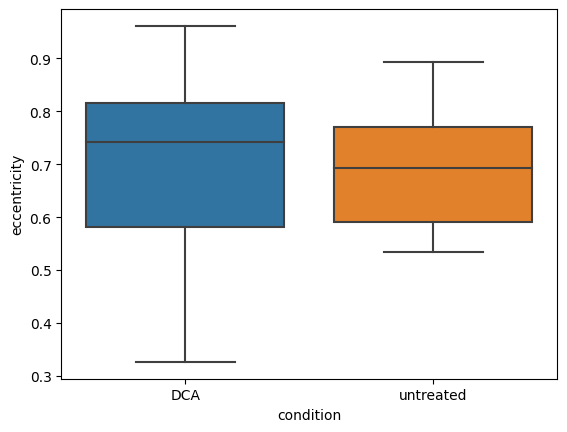

In [17]:
sns.boxplot(data=df.loc[df.mag==2500,:],x='condition',y='eccentricity')

### Plot number of mitochondria detected per cell

In [18]:
# choose mitochondria that belong to a full cell
df_sel = df.loc[df['mean_intensity-1'] > 0,:]
len(df_sel)

352

In [19]:
cat = ['untreated','DCA']
for c in cat:
    print(f'Number of full cells in category {c} = {len(set(df_sel.loc[df_sel.condition==c,"mean_intensity-1"]))}')

Number of full cells in category untreated = 21
Number of full cells in category DCA = 30


In [20]:
df_count = pd.DataFrame(df_sel.loc[:,['condition','source_im','mean_intensity-1','label']].groupby(by=['condition','source_im','mean_intensity-1']).count())
df_count.reset_index(inplace=True)
df_count

,condition,source_im,mean_intensity-1,label
0,DCA,300k_DCA_pic13_collected,198.0,5
1,DCA,300k_DCA_pic13_collected,199.0,4
2,DCA,300k_DCA_pic13_collected,200.0,6
3,DCA,300k_DCA_pic13_collected,203.0,12
4,DCA,300k_DCA_pic13_collected,206.0,6
...,...,...,...,...
61,untreated,300k_ut_pic14_collected,4.0,5
62,untreated,300k_ut_pic14_collected,6.0,2
63,untreated,300k_ut_pic9_collected,13.0,6
64,untreated,300k_ut_pic9_collected,14.0,1


<AxesSubplot:xlabel='condition', ylabel='label'>

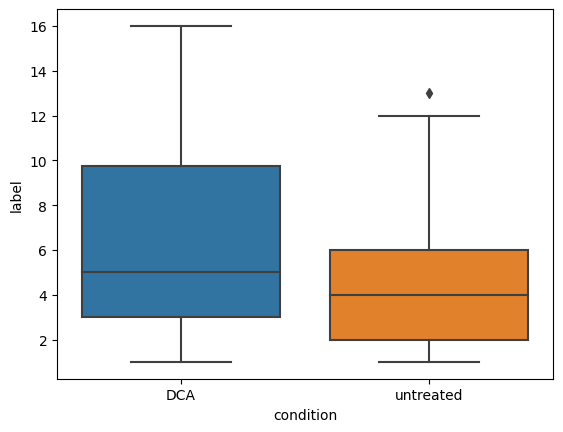

In [21]:
# here be careful with interpretation because we cannot guarantee that all mitochondria were detected
sns.boxplot(data=df_count,x='condition',y='label')